## 1. Import

In [1]:
from pathlib import Path
import sys
import zipfile
import pandas as pd
from fuzzywuzzy import process
import os
from tqdm.notebook import tqdm
from mplsoccer import VerticalPitch, Standardizer
from mycolorpy import colorlist as mcp
from highlight_text import fig_text, ax_text




import warnings
warnings.filterwarnings("ignore")

# Get the absolute path to the 'utils' directory, which is assumed to be
# in the parent directory of the current Jupyter notebook's location.
utils_dir = str(Path.cwd().parent / "utils")

# Add the 'utils' directory to sys.path if it's not already included.
if utils_dir not in sys.path:
    sys.path.append(utils_dir)

# Import all functions from the '../utils/utils.py' and  directory.
from utils import *

/Users/mikhailborodastov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/mikhailborodastov/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 2. Load data

### 2.1. Opta event data (whoscored.com)

- `event_data_top5_leagues_18032024.csv` The file contains event data (just shots) scraped from whoscored.com for the top 5 European leagues for a specific date (15 March 2024).

In [2]:
os.listdir('../data')

['.DS_Store', 'event_data_top5_leagues_18032024_(shots).csv.zip']

In [3]:
%%time
path_to_zip_file = '../data/event_data_top5_leagues_18032024_(shots).csv.zip'
file_name = 'event_data_top5_leagues_18032024_(shots).csv'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    
    with zip_ref.open(file_name) as file:
        
        DF = pd.read_csv(file)

CPU times: user 957 ms, sys: 39 ms, total: 996 ms
Wall time: 534 ms


In [4]:
print(f'DF shape: {DF.shape}')

total_memory = round(DF.memory_usage(deep=True).sum() / (1024**2))
print(f"DF memory usage in Mb: {total_memory}")

DF shape: (34380, 265)
DF memory usage in Mb: 76


### 2.2 Opta xG statistic (FBref.com)

In [5]:
sorted(os.listdir('../../Scraping_fbref_static_data/data/current_season'))

['.DS_Store',
 '2024-03-02',
 '2024-03-06',
 '2024-03-08',
 '2024-03-12',
 '2024-03-18']

In [6]:
date = '2024-03-18'

os.listdir(f'../../Scraping_fbref_static_data/data/current_season/{date}')

['top5_leagues_team_vs_2023_2024.csv',
 'top5_leagues_team_2023_2024.csv',
 'top5_leagues_outfields_2023_2024.csv',
 'top5_leagues_keeper_2023_2024.csv']

In [7]:
path2 = '../../Scraping_fbref_static_data/data/current_season'

#### Get all players data for TOP5 europe leagues current season

In [8]:
#TOP5 europen leagues current seasons (up-to-{date})
df_statistics = pd.read_csv('/'.join((path2, date, 'top5_leagues_outfields_2023_2024.csv')), index_col=0).reset_index(drop=True)

## 3. Preprocessing data

### 3.1 Filter to keep only shots, excluding penalties (events)

- Opta data categorizes shots into four types:

    - `SavedShot`
    - `MissedShots`
    - `Goal`
    - `ShotOnPost`
    

In [9]:
mask = DF['type'].apply(lambda x: x in ['SavedShot','MissedShots','Goal','ShotOnPost'])
mask2 = DF['situation'] != 'Penalty'


df_events = DF[mask & mask2]
df_events['playerId'] = df_events['playerId'].astype(int)

In [10]:
# df_events.to_csv('test.csv', index=False)
# df_events = pd.read_csv('test.csv')

In [11]:
df_events.shape

(34380, 265)

### 3.2 Mapping team names and player names from two sources

### 3.2.1 Mapping teams

In [14]:
whoscored_teams = set(df_events['teamName'])
fbref_teams = set(df_statistics['team'])


unmatched_names_list = list(whoscored_teams.difference(fbref_teams))

print(len(unmatched_names_list))

36


In [15]:
print(f'unmatched team names: {len(unmatched_names_list) / len(whoscored_teams)*100}%')

unmatched team names: 37.5%


#### Use fuzzywuzzy.process to map team names from df_events to df_statistics

In [16]:
names_list1 = list(unmatched_names_list)
names_list2 = list(fbref_teams)

cutoff = 80

fuzzy_matches = {name : process.extractOne(name, names_list2, score_cutoff=cutoff) for name in names_list1}

sorted_fuzzy_matches = dict(sorted(fuzzy_matches.items(), key=sort_key, reverse=True))

sorted_fuzzy_matches

{'Newcastle': ('Newcastle Utd', 95),
 'Darmstadt': ('Darmstadt 98', 95),
 'Crystal_Palace': ('Crystal Palace', 93),
 'Rayo_Vallecano': ('Rayo Vallecano', 93),
 'Real_Sociedad': ('Real Sociedad', 92),
 'Werder_Bremen': ('Werder Bremen', 92),
 'Union_Berlin': ('Union Berlin', 92),
 'Clermont_Foot': ('Clermont Foot', 92),
 'Almeria': ('Almería', 92),
 'Athletic_Club': ('Athletic Club', 92),
 'Aston_Villa': ('Aston Villa', 91),
 'Real_Madrid': ('Real Madrid', 91),
 'Celta_Vigo': ('Celta Vigo', 90),
 'Las_Palmas': ('Las Palmas', 90),
 'Borussia_Dortmund': ('Dortmund', 90),
 'Real_Betis': ('Betis', 90),
 'Verona': ('Hellas Verona', 90),
 'Mainz': ('Mainz 05', 90),
 'AC_Milan': ('Milan', 90),
 'Bayern': ('Bayern Munich', 90),
 'Borussia_M.Gladbach': ("M'Gladbach", 90),
 'Luton': ('Luton Town', 90),
 'Cadiz': ('Cádiz', 89),
 'West_Ham': ('West Ham', 88),
 'Le_Havre': ('Le Havre', 88),
 'FC_Heidenheim': ('Heidenheim', 87),
 'Nottingham_Forest': ("Nott'ham Forest", 81),
 'Deportivo_Alaves': None

#### Unmatched names, manually processed

In [17]:
fuzzy_matches['Man_City'] = ('Manchester City',100)
fuzzy_matches['Eintracht_Frankfurt'] = ('Eint Frankfurt',100)
fuzzy_matches['FC_Koln'] = ('Köln',100)
fuzzy_matches['Atletico'] = ('Atlético Madrid',100)
fuzzy_matches['Man_Utd'] = ('Manchester Utd',100)
fuzzy_matches['Deportivo_Alaves'] = ('Alavés',100)
fuzzy_matches['Sheff_Utd'] = ('Sheffield Utd',100)
fuzzy_matches['PSG'] = ('Paris S-G',100)
fuzzy_matches['RBL'] = ('RB Leipzig',100)

In [18]:
# SEARCHING = 'leip'

# mask = df_statistics['team'].apply(lambda x: SEARCHING in x.lower())
# df_statistics[mask]['team'].unique()

In [19]:
fuzzy_matches_filtered = {k: v[0] if v is not None else v for k, v in fuzzy_matches.items()}
inverted_fuzzy_matches = {v: k for k, v in fuzzy_matches_filtered.items()}

#### Change team name for df_statistics

In [20]:
df_statistics['team'] = df_statistics['team'].apply(lambda x: inverted_fuzzy_matches[x] if x in inverted_fuzzy_matches.keys() else x)

whoscored_teams = set(df_events['teamName'])
fbref_teams = set(df_statistics['team'])


unmatched_names_list = list(whoscored_teams.difference(fbref_teams))

print(len(unmatched_names_list))


0


### 3.2.2 Mapping players

In [21]:
mask = df_events['playerName'].apply(lambda x: 'ronal' in x.lower())
df_events[mask].set_index(['playerName','teamName']).index.unique()

MultiIndex([('Ronald Araújo', 'Barcelona'),
            ('Ronald Araujo', 'Barcelona')],
           names=['playerName', 'teamName'])

#### Remove diacritics

In [22]:
df_events['playerName'] = df_events['playerName'].apply(lambda x: remove_diacritics(x))
df_statistics['player'] = df_statistics['player'].apply(lambda x: remove_diacritics(x))

In [23]:
mask = df_events['playerName'].apply(lambda x: 'ronal' in x.lower())
df_events[mask].set_index(['playerName','teamName']).index.unique()

MultiIndex([('Ronald Araujo', 'Barcelona')],
           names=['playerName', 'teamName'])

#### Keep 1 unique playerName for playerId

In [24]:
proxy = df_events.groupby('playerId').agg({'playerName':'nunique'})
mask = proxy['playerName'] > 1
num = proxy[mask].shape[0]
print(f'Number of playerId with more then 1 playerName: {num}\n')

print('Examples:\n')
for ind in proxy[mask].index[:5]:
    
    mask = df_events['playerId'] == ind
    names = df_events[mask]['playerName'].unique()
    print(f'playerId {ind}, names: {names}')



Number of playerId with more then 1 playerName: 18

Examples:

playerId 33875, names: ['Marco Faraoni' 'Davide Faraoni']
playerId 261698, names: ['Melero' 'Gonzalo Melero']
playerId 344119, names: ['Maximiliano Gomez' 'Maxi Gomez']
playerId 349561, names: ['Frank Anguissa' 'Andre-Frank Zambo Anguissa']
playerId 357118, names: ['Miguel Rubio' 'Miguel Angel Rubio']


In [25]:
mask = proxy['playerName'] > 1

for ind in proxy[mask].index:
    
    mask = df_events['playerId'] == ind
    names = df_events[mask]['playerName'].unique()
    final_name = max(names)
    df_events.loc[mask,'playerName'] = final_name

In [26]:
proxy = df_events.groupby('playerId').agg({'playerName':'nunique'})
mask = proxy['playerName'] > 1
num = proxy[mask].shape[0]
print(f'Number of playerId with more then 1 playerName: {num}\n')

Number of playerId with more then 1 playerName: 0



#### Count of Unmatched Player-Team Name Combinations

In [27]:
whoscored_players = set(df_events.set_index(['teamName','playerName']).index)
fbref_players = set(df_statistics.set_index(['team','player']).index)


unmatched_names_list = list(whoscored_players.difference(fbref_players))

print(len(unmatched_names_list))

191


In [28]:
print(f'unmatched team+player names: {round(len(unmatched_names_list) / len(whoscored_players)*100,1)}%')

unmatched team+player names: 8.4%


In [29]:
whoscored_players = set(df_events.set_index(['playerName']).index)
fbref_players = set(df_statistics.set_index(['player']).index)


unmatched_names_list = list(whoscored_players.difference(fbref_players))

print(len(unmatched_names_list))

177


In [30]:
print(f'unmatched player names: {round(len(unmatched_names_list) / len(whoscored_players)*100,1)}%')

unmatched player names: 8.2%


#### Some players have one-to-many relationships with teams

In [31]:
proxy = df_events.groupby(['playerName']).agg({'teamName':'nunique'}).sort_values('teamName')
mask = proxy['teamName'] > 1
proxy[mask]

teamName
playerName                  
Ian Maatsen                2
Nemanja Matic              2
Borja Iglesias             2
Bryan Zaragoza             2
Eric Garcia                2
...                      ...
Pasquale Mazzocchi         2
Milan Djuric               2
David Datro Fofana         2
Niclas Fullkrug            2
Vitinha                    3

[105 rows x 1 columns]

#### Example

In [32]:
df_events[df_events['playerName'] == 'Vitinha']['teamName'].unique()

array(['Marseille', 'PSG', 'Genoa'], dtype=object)

In [33]:
# mask = df_events['playerName'].apply(lambda x: 'vitin' in x.lower())
# df_events[mask]['playerName'].unique()

In [34]:
proxy = df_statistics.groupby(['player']).agg({'team':'nunique'}).sort_values('team')
mask = proxy['team'] > 1
proxy[mask]

team
player                  
Yann Karamoh           2
Christophe Herelle     2
Romain Faivre          2
Jon Karrikaburu        2
Julien Le Cardinal     2
...                  ...
Dean Henderson         2
Kevin Vogt             2
Marco Pellegrino       2
Vitinha                3
Andrey Santos          3

[191 rows x 1 columns]

#### Example

In [35]:
df_statistics[df_statistics['player'] == 'Vitinha']

season league_name   player nationality position       team     age  \
2559  2023-2024     Serie-A  Vitinha      pt POR       FW      Genoa  24-003   
3268  2023-2024     Ligue-1  Vitinha      pt POR       FW  Marseille  24-003   
3269  2023-2024     Ligue-1  Vitinha      pt POR       MF        PSG  24-034   

      birth_year  games  games_starts  ...  on_goals_for  on_goals_against  \
2559      2000.0    5.0           0.0  ...           2.0               4.0   
3268      2000.0   18.0          10.0  ...          17.0              10.0   
3269      2000.0   23.0          18.0  ...          40.0              16.0   

      plus_minus  plus_minus_per90  plus_minus_wowy  on_xg_for  on_xg_against  \
2559        -2.0             -1.87            -1.76        2.4            2.4   
3268         7.0              0.68             0.21       20.6            9.6   
3269        24.0              1.29            -0.44       38.9           22.3   

      xg_plus_minus  xg_plus_minus_per90  xg_plus_minus_wowy  
2559           -0.1                -0.06                0.11  
3268           10.9                 1.07                0.57  
3269           16.6                 0.88                0.09  

[3 rows x 204 columns]

<b>Note</b>:
- Player names are not unique
    - Vitinha https://www.transfermarkt.world/vitinha/profil/spieler/586853)
    - Vitinha https://www.transfermarkt.world/vitinha/profil/spieler/487469)
- When a players change clubs during the season, they will be represented in several teams.
    - Vitinha https://www.transfermarkt.world/vitinha/profil/spieler/586853)

#### Create dict

1. `dict_result`
- team name
    - player name (df_events)
        - closest player name from df_statistic
        
2. `dict_unmatched`
- team name
    - player name (df_events)
        - None (unmatched name)
        

In [36]:
teams = df_events['teamName'].unique()

dict_result = {}
dict_unmatched = {}

for team in tqdm(teams):
    
    df_1 = df_events[df_events['teamName'] == team]
    df_2 = df_statistics[df_statistics['team'] == team]
    
    whoscored_players = df_1['playerName'].unique()
    fbref_players = df_2['player'].unique()
    
    cutoff = 80
    
    dict_result[team] = {}
    
    for name in whoscored_players:
        
        result = process.extractOne(name, fbref_players, score_cutoff=cutoff)
        
        if result != None:
            dict_result[team][name] = result
        else:
            if team not in dict_unmatched.keys():
                dict_unmatched[team] = {}
                dict_unmatched[team][name] = result
            else:
                dict_unmatched[team][name] = result
    
    
    
    

  0%|          | 0/96 [00:00<?, ?it/s]

In [37]:
len(dict_result)

96

In [38]:
len(dict_unmatched)

23

In [39]:
dict_unmatched

{'Getafe': {'Jorge Martin': None, 'Yellu Santiago': None},
 'Cadiz': {'Momo Mbaye': None},
 'Osasuna': {'Chimy Avila': None},
 'Real_Betis': {'Chimy Avila': None},
 'Sevilla': {'Isaac Romero': None},
 'Granada': {'Miki Bosch': None},
 'Athletic_Club': {'Malcom Adu': None},
 'Valencia': {'Pepelu': None},
 'Almeria': {'Marezi': None, 'Chumi': None, 'Rachad Dhimi': None},
 'Las_Palmas': {'Pejino': None},
 'Arsenal': {'Gabriel Magalhaes': None},
 'Brentford': {'Zanka': None},
 'Strasbourg': {'Habib Diarra': None},
 'Montpellier': {'Kiki Kouyate': None},
 'Rennes': {'Aboubakar Nagida': None, 'Bertug Yildirim': None},
 'Lorient': {'Isaak Toure': None, 'Igor Silva': None},
 'Roma': {'Evan Ndicka': None},
 'Verona': {'Marco Faraoni': None},
 'Fiorentina': {'Marco Faraoni': None},
 'Monza': {'Jose Machin': None},
 'Salernitana': {'Simy': None},
 'FC_Koln': {'Jeff Chabot': None},
 'Borussia_M.Gladbach': {'Manu Kone': None, 'Jordan Siebatcheu': None}}

#### Manualy fill unmatched players

In [40]:
mask = df_statistics['player'].apply(lambda x: 'santia' in x.lower())
df_statistics[mask].set_index(['player','team']).index.unique()

MultiIndex([(   'Santiago Bueno',    'Wolves'),
            (    'Yago Santiago', 'Tottenham'),
            (  'Santiago Garcia',    'Getafe'),
            (   'Jesus Santiago',    'Getafe'),
            (   'Santiago Bueno',    'Girona'),
            (  'Santiago Castro',   'Bologna'),
            ('Santiago Pierotti',     'Lecce')],
           names=['player', 'team'])

In [41]:
dict_result['Getafe']['Jorge Martin'] = ('Jorge Benito',100)
dict_result['Getafe']['Yellu Santiago'] = ('Jesus Santiago',100)
dict_result['Cadiz']['Momo Mbaye'] = ('Mamadou Mbaye',100)
dict_result['Osasuna']['Chimy Avila'] = ('Ezequiel Avila',100)
dict_result['Real_Betis']['Chimy Avila'] = ('Ezequiel Avila',100)
dict_result['Sevilla']['Isaac Romero'] = ('Isaac Bernal',100)
dict_result['Granada']['Miki Bosch'] = ('Adri Bosch',100)
dict_result['Athletic_Club']['Malcom Adu'] = ('Adu Ares',100)
dict_result['Valencia']['Pepelu'] = ('Jose Luis Garcia Vaya',100)
dict_result['Almeria']['Marezi'] = ('Marko Milovanovic',100)
dict_result['Almeria']['Chumi'] = ('Juan Brandariz',100)
dict_result['Almeria']['Rachad Dhimi'] = ('Rachad Fettal',100)
dict_result['Las_Palmas']['Pejino'] = ('Francisco Jesus Crespo Garcia',100)
dict_result['Arsenal']['Gabriel Magalhaes'] = ('Gabriel Dos Santos',100)
dict_result['Brentford']['Zanka'] = ('Mathias Jørgensen',100)
dict_result['Strasbourg']['Habib Diarra'] = ('Mouhamadou Diarra',100)
dict_result['Montpellier']['Kiki Kouyate'] = ('Boubakar Kouyate',100)
dict_result['Rennes']['Aboubakar Nagida'] = ('Mahamadou Nagida',100)
dict_result['Rennes']['Bertug Yildirim'] = ('Bertug Ozgur Yıldırım',100)
dict_result['Lorient']['Isaak Toure'] = ('Souleymane Toure',100)
dict_result['Lorient']['Igor Silva'] = ('Igor Carioca',100)
dict_result['Roma']['Evan Ndicka'] = ("Obite N'Dicka",100)
dict_result['Verona']['Marco Faraoni'] = ('Davide Faraoni',100)
dict_result['Fiorentina']['Marco Faraoni'] = ('Davide Faraoni',100)
dict_result['Monza']['Jose Machin'] = ('Pepin',100)
dict_result['Salernitana']['Simy'] = ('Simeon Nwankwo',100)
dict_result['FC_Koln']['Jeff Chabot'] = ('Julian Chabot',100)
dict_result['Borussia_M.Gladbach']['Manu Kone'] = ('Kouadio Kone',100)
dict_result['Borussia_M.Gladbach']['Jordan Siebatcheu'] = ('Jordan Pefok',100)

#
dict_result['Almeria']['Alex Pozo'] = ('Alejandro Pozo Pozo', 100)
dict_result['Verona']['Juan Manuel Cruz'] = ('Juan Cruz', 100)


In [42]:
inverted_fuzzy_matches = {}

for key, _ in dict_result.items():
    inverted_dict = {v[0] : k for k, v in dict_result[key].items()}
    inverted_fuzzy_matches[key] = inverted_dict

#### Change player names for df_statistics

In [43]:
df_statistics['player'] = df_statistics[['team','player']].apply(lambda x: inverted_fuzzy_matches[x[0]][x[1]] if x[1] in inverted_fuzzy_matches[x[0]].keys() else x[1], axis=1)

In [44]:
whoscored_players = set(df_events.set_index(['teamName','playerName']).index)
fbref_players = set(df_statistics.set_index(['team','player']).index)


unmatched_names_list = list(whoscored_players.difference(fbref_players))

print(len(unmatched_names_list))

unmatched_names_list

0


[]

### 4.3 Calculate additional statistics

Add cooridnates for uefa pitch_type

In [45]:
opta_to_custom = Standardizer(pitch_from='opta',
                              pitch_to='uefa')

df_events['x_'], df_events['y_'] = opta_to_custom.transform(x=df_events['x'].values, 
                                                    y=df_events['y'].values)

Counting shots made from both inside and outside the penalty area.

In [46]:
df_events['is_in_box'] = [is_inside_box(x,y) for x,y in zip(df_events['y'], df_events['x'])]
df_events_gr = df_events.groupby(['league_name','playerId', 'playerName', 'teamName', 'is_in_box'])['minute'].count().reset_index()
df_events_gr = df_events_gr.pivot(columns='is_in_box', index=['league_name','playerId', 'playerName', 'teamName'], values='minute').reset_index()
df_events_gr.columns = ['league_name','playerId', 'playerName', 'teamName', 'outside','inside']
df_events_gr.fillna(0, inplace=True)
df_events_gr['total'] = df_events_gr['inside'] + df_events_gr['outside']
df_events_gr['share'] = df_events_gr['inside']/df_events_gr['total']
df_events_gr

league_name  playerId              playerName           teamName  \
0     Bundesliga     19910       Norman Theuerkauf      FC_Heidenheim   
1     Bundesliga     20664        Leonardo Bonucci       Union_Berlin   
2     Bundesliga     21541            Mats Hummels  Borussia_Dortmund   
3     Bundesliga     29809      Eric Choupo-Moting             Bayern   
4     Bundesliga     35776         Cristian Gamboa             Bochum   
...          ...       ...                     ...                ...   
2264     Serie_A    495260           Patrick Dorgu              Lecce   
2265     Serie_A    495566          Stiven Shpendi             Empoli   
2266     Serie_A    496302         Tommaso Corazza            Bologna   
2267     Serie_A    497758  Chukwubuikem Ikwuemesi        Salernitana   
2268     Serie_A    498183         Mateus Lusuardi          Frosinone   

      outside  inside  total     share  
0         2.0     4.0    6.0  0.666667  
1         0.0     1.0    1.0  1.000000  
2         2.0    11.0   13.0  0.846154  
3         1.0    20.0   21.0  0.952381  
4         6.0     0.0    6.0  0.000000  
...       ...     ...    ...       ...  
2264      4.0     4.0    8.0  0.500000  
2265      1.0     4.0    5.0  0.800000  
2266      0.0     1.0    1.0  1.000000  
2267      4.0    12.0   16.0  0.750000  
2268      0.0     1.0    1.0  1.000000  

[2269 rows x 8 columns]

## 5. Set specific league and get raitings

In [47]:
df_statistics['league_name'].unique()

array(['Premier-League', 'Bundesliga', 'La-Liga', 'Serie-A', 'Ligue-1'],
      dtype=object)

#### Below, 3 types of ratings will be plotted

In [48]:
rating_types = {'shots_per90':'Shots',
              'goals_pens_per90':'np Goals',
              'npxg_per90':'npxG'}

#### We need to choose either all 5 leagues, in which case the title will be 'Europe', or just one of the 5 leagues.

In [49]:
leagues = ['Premier-League', 'Bundesliga', 'La-Liga', 'Serie-A', 'Ligue-1']

### 5.1 The best Shooters (ranking by shots per 90 min)

- TOP5 Europen leagues

#### Filter df_statistcs

In [50]:
min_minutes_90s = 14
rating_size = 9

rating_type = 'shots_per90'

type_ = rating_types[rating_type]

# leagues = ['Premier-League']

columns = ['player','team','xg','npxg','goals','goals_pens','shots','goals_per_shot','npxg_per_shot',
           'shots_on_target','shots_on_target_pct','average_shot_distance','games', 'minutes_90s','shots_per90',
           'goals_pens_per90','npxg_per90']

mask1 = df_statistics['league_name'].apply(lambda x: x in leagues)
mask2 = df_statistics['minutes_90s'] > min_minutes_90s

df_statistics_filtered = (df_statistics[mask1 & mask2][columns]
                .sort_values([rating_type,'goals_pens_per90'], ascending=[False,False])
                .head(rating_size)
                .reset_index(drop=True)
                 )
df_statistics_filtered

player        team    xg  npxg  goals  goals_pens  shots  \
0        Victor Boniface  Leverkusen  12.1  11.3   10.0         9.0   70.0   
1          Kylian Mbappe         PSG  18.7  12.3   21.0        15.0   95.0   
2           Darwin Nunez   Liverpool  13.5  12.7   10.0        10.0   85.0   
3             Harry Kane      Bayern  25.5  23.2   31.0        28.0  116.0   
4            Deniz Undav   Stuttgart  11.6  10.8   14.0        14.0   71.0   
5         Dusan Vlahovic    Juventus  13.0   9.7   15.0        13.0   83.0   
6  Khvicha Kvaratskhelia      Napoli   9.3   9.3   10.0        10.0   99.0   
7            Lois Openda         RBL  18.0  15.6   19.0        17.0   94.0   
8         Erling Haaland    Man_City  20.9  17.8   18.0        15.0   87.0   

   goals_per_shot  npxg_per_shot  shots_on_target  shots_on_target_pct  \
0            0.13           0.16             28.0                 40.0   
1            0.16           0.13             40.0                 42.1   
2            0.12           0.15             37.0                 43.5   
3            0.24           0.20             51.0                 44.0   
4            0.20           0.15             36.0                 50.7   
5            0.16           0.12             28.0                 33.7   
6            0.10           0.09             35.0                 35.4   
7            0.18           0.17             46.0                 48.9   
8            0.17           0.21             39.0                 44.8   

   average_shot_distance  games  minutes_90s  shots_per90  goals_pens_per90  \
0                   15.7   16.0         14.2         4.94              0.63   
1                   18.6   23.0         19.5         4.87              0.77   
2                   15.0   26.0         17.5         4.87              0.57   
3                   14.0   26.0         25.5         4.54              1.10   
4                   16.3   22.0         15.6         4.54              0.89   
5                   15.9   24.0         18.6         4.46              0.70   
6                   18.1   26.0         23.1         4.28              0.43   
7                   14.1   26.0         22.5         4.18              0.76   
8                   11.5   23.0         21.4         4.07              0.70   

   npxg_per90  
0        0.79  
1        0.63  
2        0.73  
3        0.91  
4        0.69  
5        0.52  
6        0.40  
7        0.69  
8        0.83

#### Merge df_statistics_filtered with df_events_gr

In [51]:
print(df_events_gr.shape)
print(df_statistics_filtered.shape)

DF_merged = pd.merge(df_statistics_filtered, df_events_gr, 
             left_on = ['player', 'team'],
             right_on = ['playerName', 'teamName'],
             how='left')

print(DF_merged.shape)

(2269, 8)
(9, 17)
(9, 25)


#### Add logos

In [52]:
DF_merged['league_name'].unique()

array(['Bundesliga', 'Ligue_1', 'Premier_League', 'Serie_A'], dtype=object)

- Some short names, such as PSG and RBL, need to be changed to match correctly with their logos.

In [53]:
DF_merged['teamName_plot'] = (DF_merged['teamName']
                          .replace('PSG', 'Paris S-G')
                          .replace('RBL','RB Leipzig')
)

In [54]:
# os.listdir('../logos')

path_ = '../logos'

dict_logo = {'Premier_League':'GB1',
             'Serie_A':'IT1',
             'LaLiga':'ES1',
             'Bundesliga':'L1',
             'Ligue_1':'FR1'}


for n, row in DF_merged.iterrows():
    
    league = row['league_name']
    team_name = row['teamName_plot'].replace('_',' ')
    
    path_to_league_logo = os.path.join(path_, dict_logo[league])
    
    choices = os.listdir(path_to_league_logo)
    
    logo_name_matched = process.extractOne(team_name, choices, score_cutoff=80)
    
    if logo_name_matched != None:
        logo_name_matched = logo_name_matched[0]
        path_return = os.path.join(path_to_league_logo, logo_name_matched)

        DF_merged.loc[n, 'path_logo'] = path_return


In [55]:
DF_merged[['teamName','teamName_plot','path_logo']]

teamName teamName_plot                             path_logo
0  Leverkusen    Leverkusen   ../logos/L1/Bayer 04 Leverkusen.png
1         PSG     Paris S-G  ../logos/FR1/Paris Saint-Germain.png
2   Liverpool     Liverpool         ../logos/GB1/Liverpool FC.png
3      Bayern        Bayern         ../logos/L1/Bayern Munich.png
4   Stuttgart     Stuttgart         ../logos/L1/VfB Stuttgart.png
5    Juventus      Juventus          ../logos/IT1/Juventus FC.png
6      Napoli        Napoli           ../logos/IT1/SSC Napoli.png
7         RBL    RB Leipzig            ../logos/L1/RB Leipzig.png
8    Man_City      Man_City      ../logos/GB1/Manchester City.png

#### Plot

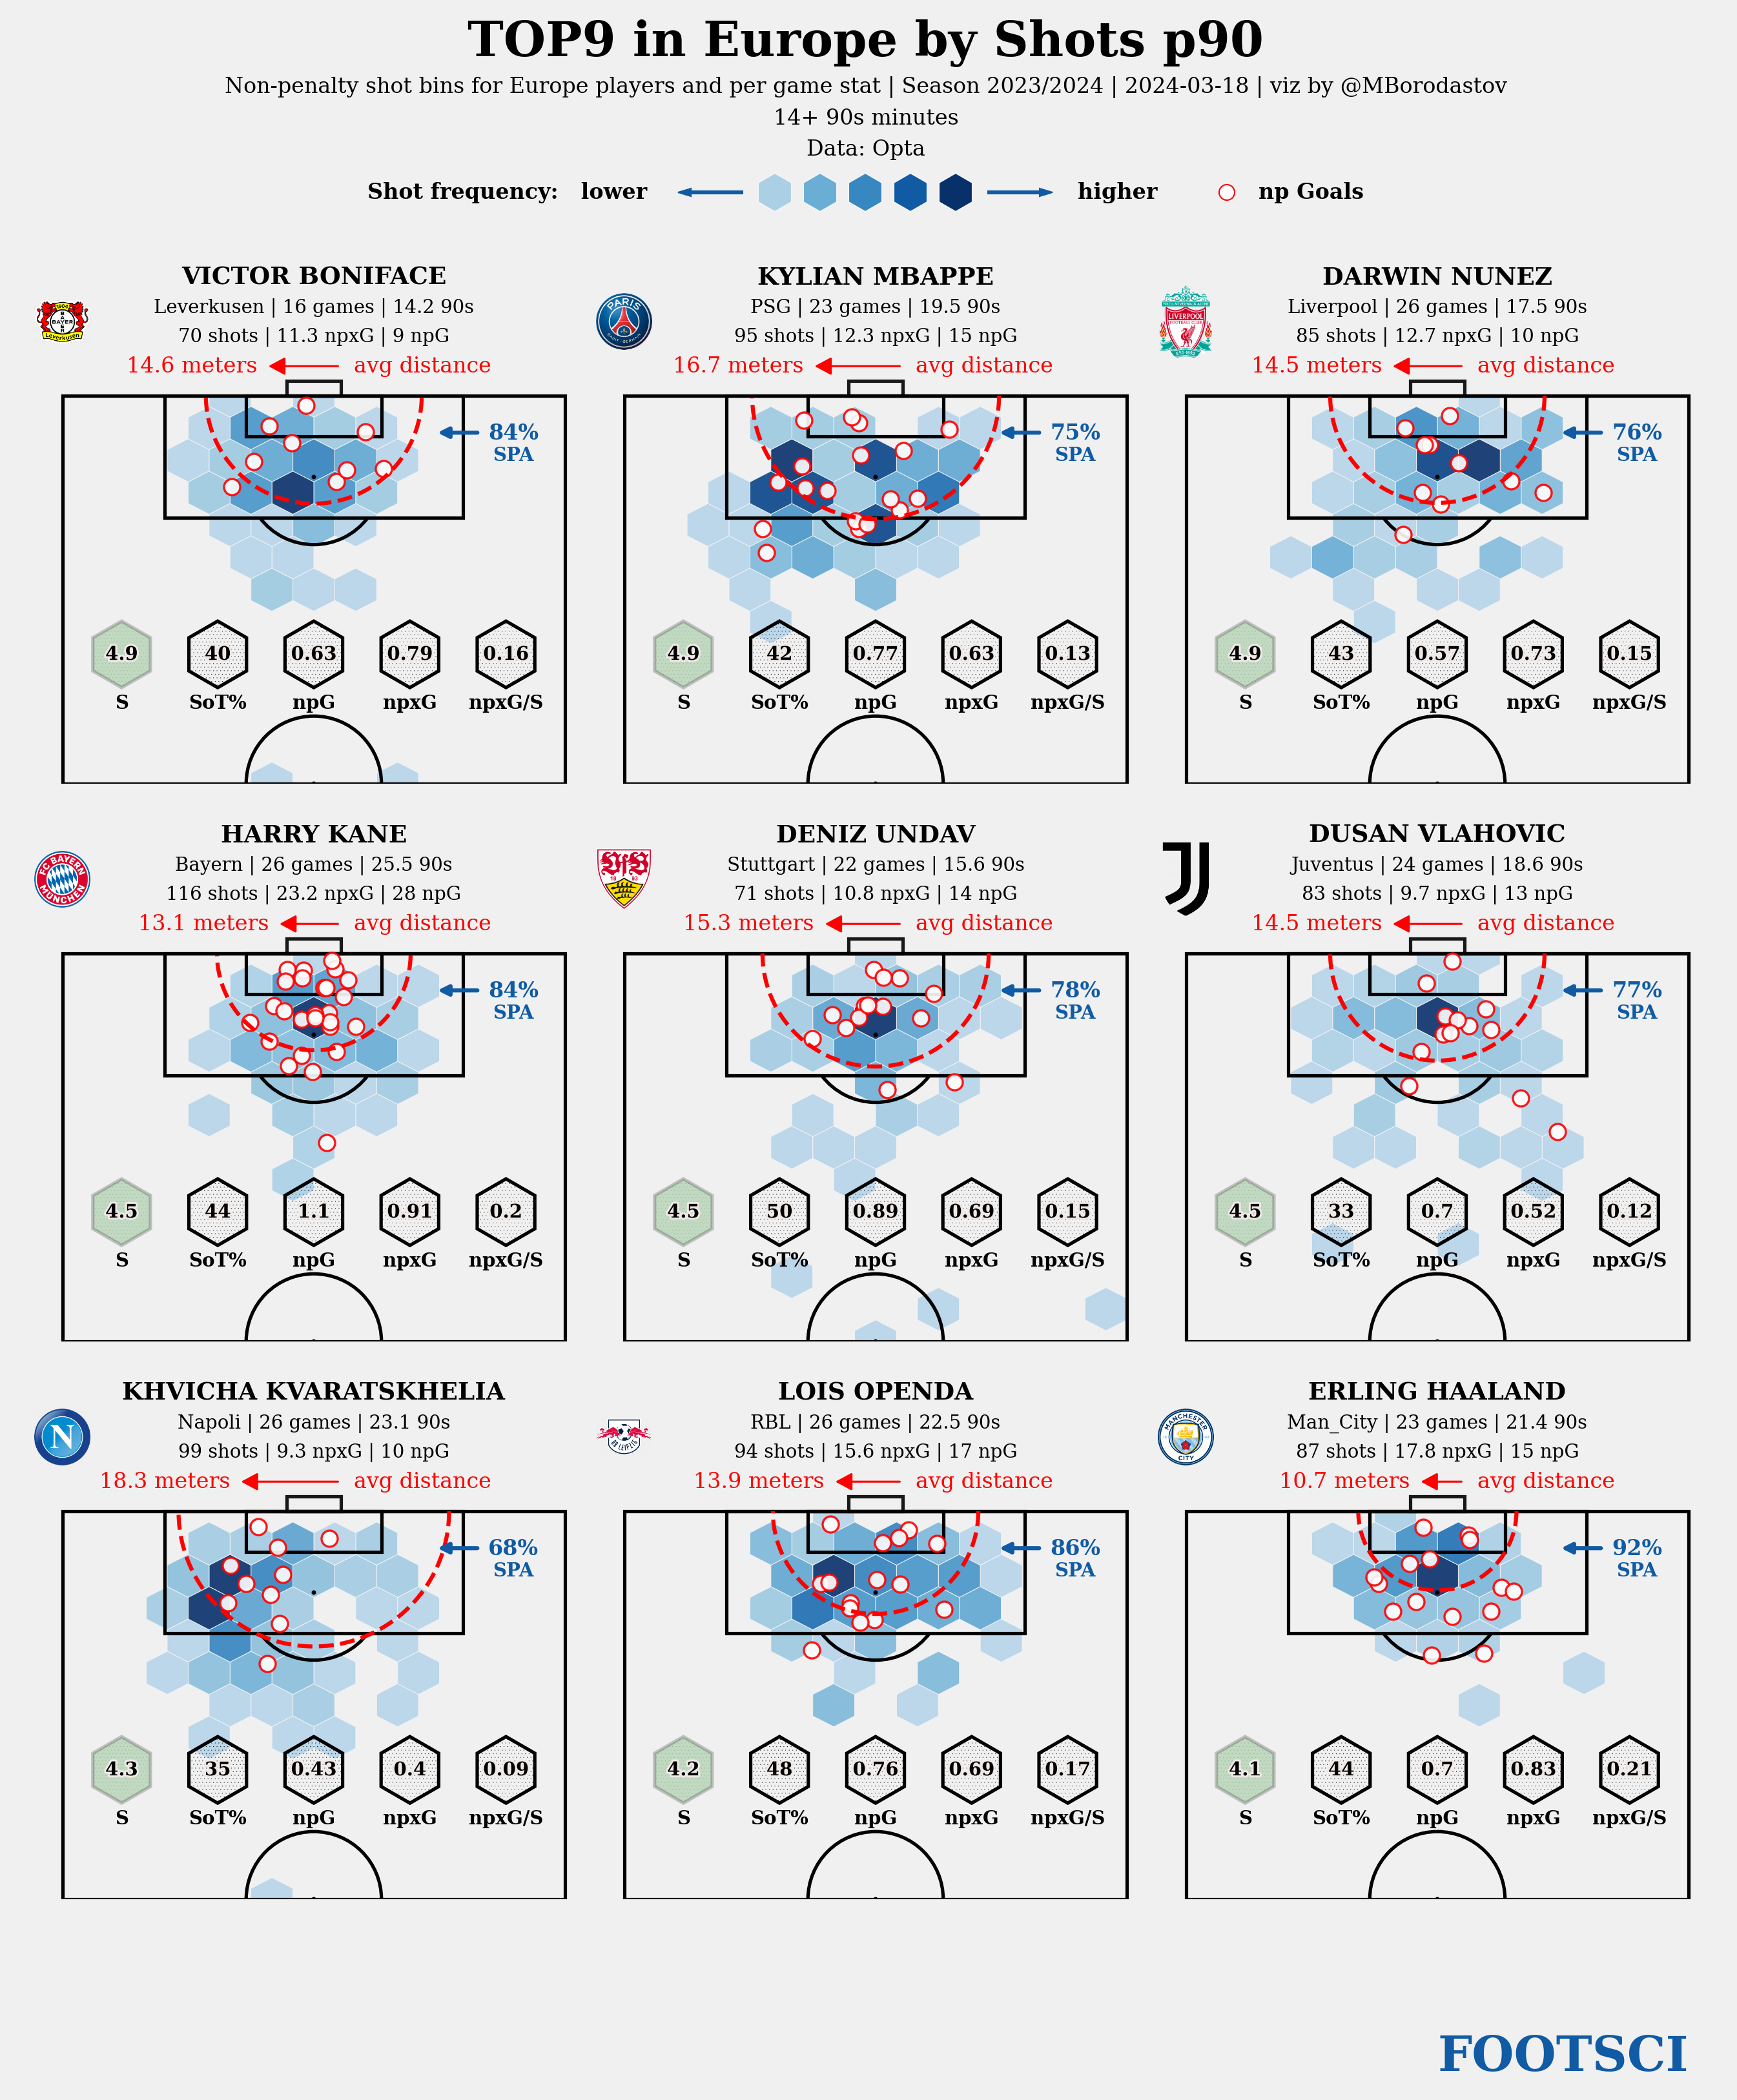

In [56]:
cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
colorlist= mcp.gen_color(cmap='Blues', n=7)
zoom_factor = 0.15

set_plot_environment()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,16), dpi=300)
axs = axs.flatten()  # Flatten the axis array for easy iteration

for index, ax in enumerate(axs):
    pitch = draw_pitch(ax)

    dict_dfs = preprocessing(DF_merged, df_events, index)

    df_all_events = dict_dfs['df_all_events']
    df_goals = dict_dfs['df_goals']
    df_statistic = dict_dfs['df_statistic']

    plot_statistics(ax, pitch, df_all_events, df_goals, cmap)
    add_image(ax, df_statistic['path_logo'].values[0], (68, 115), zoom_factor)
    plot_semicircle(ax, df_all_events, 105, 34)


    player_info = {
        'playerName': df_statistic['playerName'].values[0],
        'team': df_statistic['teamName'].values[0],
        'games': int(df_statistic['games'].values[0]),
        'minutes_90s': round(df_statistic['minutes_90s'].values[0],1),
        'shots': int(df_statistic['shots'].values[0]),
        'npxg_all': round(df_statistic['npxg'].values[0],2),
        'npgoals': int(df_statistic['goals_pens'].values[0]),
        'share' : df_statistic['share'].values[0],

        'S':round(df_statistic['shots_per90'].values[0],1),
        'SoT%':int(df_statistic['shots_on_target_pct'].values[0]),
        'npG':round(df_statistic['goals_pens_per90'].values[0],2),
        'npxG':round(df_statistic['npxg_per90'].values[0],2),
        'npxG/S':df_statistic['npxg_per_shot'].values[0]
    }

    league = 'Europe' if len(leagues) == 5 else leagues[0]

    add_annotations(ax, df_all_events, player_info, colorlist)
    add_statistics(ax, player_info,  type_=type_)
add_title(fig, ax, player_info, league, date, min_minutes_90s, colorlist, type_=type_ )

plt.subplots_adjust(wspace=0, hspace=-0.6)

if date not in os.listdir('../img/'):
    os.mkdir(f'../img/{date}/')
if league not in os.listdir(f'../img/{date}/'):
    os.mkdir(f'../img/{date}/{league}/')
    
fig.savefig(f'../img/{date}/{league}/shot_map_top{rating_size}_in_{league}_by_{type_}.jpeg', bbox_inches='tight', dpi=300)


### 5.2 TOP SCORERS (ranking by npG)

- change rating_type variable from shots_per90 to goals_pens_per90 

In [57]:
leagues = ['Premier-League', 'Bundesliga', 'La-Liga', 'Serie-A', 'Ligue-1']
min_minutes_90s = 14
rating_size = 9

rating_type = 'goals_pens_per90'
type_ = rating_types[rating_type]

columns = ['player','team','xg','npxg','goals','goals_pens','shots','goals_per_shot','npxg_per_shot',
           'shots_on_target','shots_on_target_pct','average_shot_distance','games', 'minutes_90s','shots_per90',
           'goals_pens_per90','npxg_per90']

mask1 = df_statistics['league_name'].apply(lambda x: x in leagues)
mask2 = df_statistics['minutes_90s'] > min_minutes_90s

df_statistics_filtered = (df_statistics[mask1 & mask2][columns]
                .sort_values([rating_type,'npxg_per90'], ascending=[False,False])
                .head(rating_size)
                .reset_index(drop=True)
                 )
df_statistics_filtered

player         team    xg  npxg  goals  goals_pens  shots  \
0        Harry Kane       Bayern  25.5  23.2   31.0        28.0  116.0   
1   Serhou Guirassy    Stuttgart  14.5  11.4   22.0        18.0   59.0   
2  Lautaro Martinez        Inter  14.6  12.2   23.0        21.0   76.0   
3       Deniz Undav    Stuttgart  11.6  10.8   14.0        14.0   71.0   
4     Kylian Mbappe          PSG  18.7  12.3   21.0        15.0   95.0   
5       Lois Openda          RBL  18.0  15.6   19.0        17.0   94.0   
6     Alvaro Morata     Atletico  12.1  11.3   14.0        14.0   57.0   
7   Jude Bellingham  Real_Madrid  10.3   9.5   16.0        15.0   51.0   
8    Erling Haaland     Man_City  20.9  17.8   18.0        15.0   87.0   

   goals_per_shot  npxg_per_shot  shots_on_target  shots_on_target_pct  \
0            0.24           0.20             51.0                 44.0   
1            0.31           0.19             28.0                 47.5   
2            0.28           0.16             33.0                 43.4   
3            0.20           0.15             36.0                 50.7   
4            0.16           0.13             40.0                 42.1   
5            0.18           0.17             46.0                 48.9   
6            0.25           0.20             30.0                 52.6   
7            0.29           0.19             27.0                 52.9   
8            0.17           0.21             39.0                 44.8   

   average_shot_distance  games  minutes_90s  shots_per90  goals_pens_per90  \
0                   14.0   26.0         25.5         4.54              1.10   
1                   15.0   20.0         16.6         3.55              1.08   
2                   14.0   25.0         22.5         3.38              0.93   
3                   16.3   22.0         15.6         4.54              0.89   
4                   18.6   23.0         19.5         4.87              0.77   
5                   14.1   26.0         22.5         4.18              0.76   
6                   11.4   25.0         18.5         3.08              0.76   
7                   13.8   22.0         20.7         2.46              0.72   
8                   11.5   23.0         21.4         4.07              0.70   

   npxg_per90  
0        0.91  
1        0.68  
2        0.54  
3        0.69  
4        0.63  
5        0.69  
6        0.61  
7        0.46  
8        0.83

In [58]:
print(df_events_gr.shape)
print(df_statistics_filtered.shape)

DF_merged = pd.merge(df_statistics_filtered, df_events_gr, 
             left_on = ['player', 'team'],
             right_on = ['playerName', 'teamName'],
             how='left')

print(DF_merged.shape)

(2269, 8)
(9, 17)
(9, 25)


In [59]:
DF_merged['teamName_plot'] = (DF_merged['teamName']
                          .replace('PSG', 'Paris S-G')
                          .replace('RBL','RB Leipzig')
                          .replace('Atletico','Atlético de Madrid')

)

In [60]:
# os.listdir('../logos')

path_ = '../logos'

dict_logo = {'Premier_League':'GB1',
             'Serie_A':'IT1',
             'LaLiga':'ES1',
             'Bundesliga':'L1',
             'Ligue_1':'FR1'}


for n, row in DF_merged.iterrows():
    
    league = row['league_name']
    team_name = row['teamName_plot'].replace('_',' ')
    
    path_to_league_logo = os.path.join(path_, dict_logo[league])
    
    choices = os.listdir(path_to_league_logo)
    
    logo_name_matched = process.extractOne(team_name, choices, score_cutoff=80)
    
    if logo_name_matched != None:
        logo_name_matched = logo_name_matched[0]
        path_return = os.path.join(path_to_league_logo, logo_name_matched)

        DF_merged.loc[n, 'path_logo'] = path_return



In [61]:
DF_merged[['teamName','teamName_plot','path_logo']]

teamName       teamName_plot                             path_logo
0       Bayern              Bayern         ../logos/L1/Bayern Munich.png
1    Stuttgart           Stuttgart         ../logos/L1/VfB Stuttgart.png
2        Inter               Inter          ../logos/IT1/Inter Milan.png
3    Stuttgart           Stuttgart         ../logos/L1/VfB Stuttgart.png
4          PSG           Paris S-G  ../logos/FR1/Paris Saint-Germain.png
5          RBL          RB Leipzig            ../logos/L1/RB Leipzig.png
6     Atletico  Atlético de Madrid  ../logos/ES1/Atlético de Madrid.png
7  Real_Madrid         Real_Madrid          ../logos/ES1/Real Madrid.png
8     Man_City            Man_City      ../logos/GB1/Manchester City.png

- change type_ to np Goals

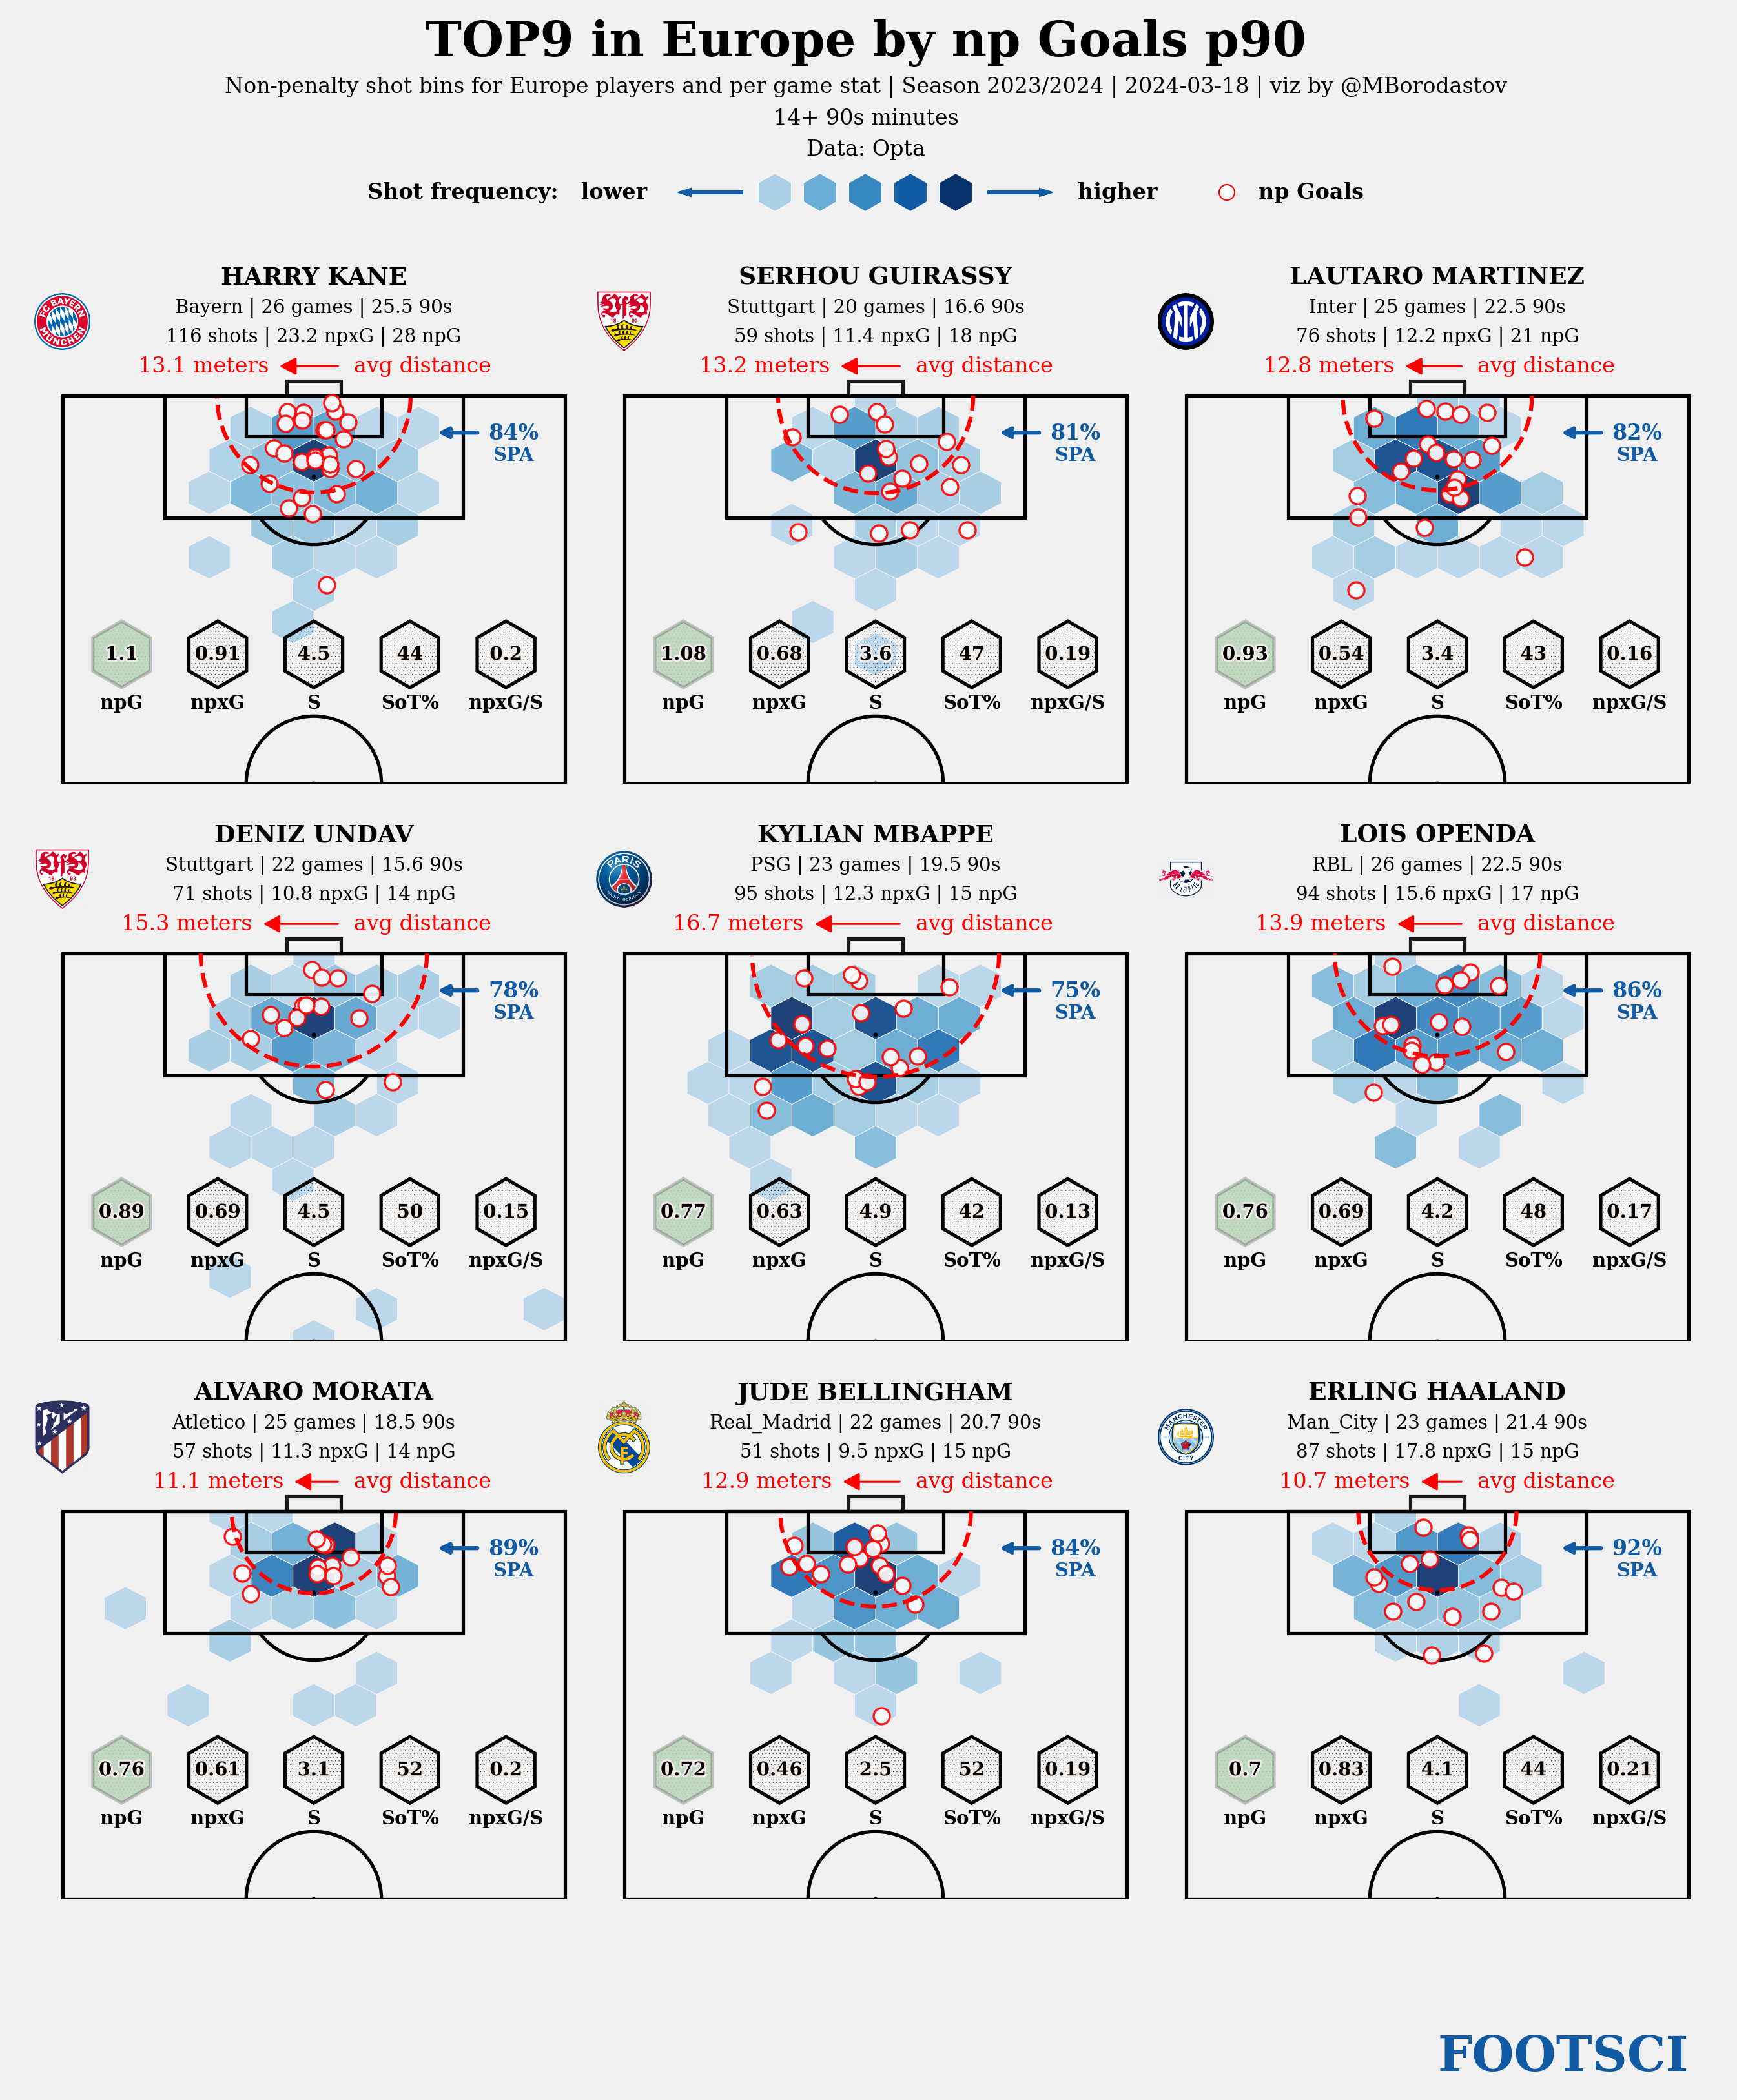

In [62]:
cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
colorlist= mcp.gen_color(cmap='Blues', n=7)
zoom_factor = 0.15

set_plot_environment()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,16), dpi=300)
axs = axs.flatten()  # Flatten the axis array for easy iteration

for index, ax in enumerate(axs):
    pitch = draw_pitch(ax)

    dict_dfs = preprocessing(DF_merged, df_events, index)

    df_all_events = dict_dfs['df_all_events']
    df_goals = dict_dfs['df_goals']
    df_statistic = dict_dfs['df_statistic']

    plot_statistics(ax, pitch, df_all_events, df_goals, cmap)
    add_image(ax, df_statistic['path_logo'].values[0], (68, 115), zoom_factor)
    plot_semicircle(ax, df_all_events, 105, 34)


    player_info = {
        'playerName': df_statistic['playerName'].values[0],
        'team': df_statistic['teamName'].values[0],
        'games': int(df_statistic['games'].values[0]),
        'minutes_90s': round(df_statistic['minutes_90s'].values[0],1),
        'shots': int(df_statistic['shots'].values[0]),
        'npxg_all': round(df_statistic['npxg'].values[0],2),
        'npgoals': int(df_statistic['goals_pens'].values[0]),
        'share' : df_statistic['share'].values[0],

        'S':round(df_statistic['shots_per90'].values[0],1),
        'SoT%':int(df_statistic['shots_on_target_pct'].values[0]),
        'npG':round(df_statistic['goals_pens_per90'].values[0],2),
        'npxG':round(df_statistic['npxg_per90'].values[0],2),
        'npxG/S':df_statistic['npxg_per_shot'].values[0]
    }

    league = 'Europe' if len(leagues) == 5 else leagues[0]

    add_annotations(ax, df_all_events, player_info, colorlist)
    add_statistics(ax, player_info,  type_=type_)
add_title(fig, ax, player_info, league, date, min_minutes_90s, colorlist, type_=type_ )

plt.subplots_adjust(wspace=0, hspace=-0.6)

if date not in os.listdir('../img/'):
    os.mkdir(f'../img/{date}/')
if league not in os.listdir(f'../img/{date}/'):
    os.mkdir(f'../img/{date}/{league}/')
    
fig.savefig(f'../img/{date}/{league}/shot_map_top{rating_size}_in_{league}_by_{type_}.jpeg', bbox_inches='tight', dpi=300)


## 5.3 TOP BY npXG

- change rating_type variable `goals_pens_per90` to `npxg_per90`

In [63]:
leagues = ['Premier-League', 'Bundesliga', 'La-Liga', 'Serie-A', 'Ligue-1']
min_minutes_90s = 14
rating_size = 9

rating_type = 'npxg_per90'
type_ = rating_types[rating_type]

columns = ['player','team','xg','npxg','goals','goals_pens','shots','goals_per_shot','npxg_per_shot',
           'shots_on_target','shots_on_target_pct','average_shot_distance','games', 'minutes_90s','shots_per90',
           'goals_pens_per90','npxg_per90']

mask1 = df_statistics['league_name'].apply(lambda x: x in leagues)
mask2 = df_statistics['minutes_90s'] > min_minutes_90s

df_statistics_filtered = (df_statistics[mask1 & mask2][columns]
                .sort_values([rating_type,'goals_pens_per90'], ascending=[False,False])
                .head(rating_size)
                .reset_index(drop=True)
                 )

print(df_events_gr.shape)
print(df_statistics_filtered.shape)

DF_merged = pd.merge(df_statistics_filtered, df_events_gr, 
             left_on = ['player', 'team'],
             right_on = ['playerName', 'teamName'],
             how='left')

print(DF_merged.shape)

DF_merged['teamName_plot'] = (DF_merged['teamName']
                          .replace('PSG', 'Paris S-G')
                          .replace('RBL','RB Leipzig')
                          .replace('Atletico','Atlético de Madrid')

)

path_ = '../logos'

dict_logo = {'Premier_League':'GB1',
             'Serie_A':'IT1',
             'LaLiga':'ES1',
             'Bundesliga':'L1',
             'Ligue_1':'FR1'}


for n, row in DF_merged.iterrows():
    
    league = row['league_name']
    team_name = row['teamName_plot'].replace('_',' ')
    
    path_to_league_logo = os.path.join(path_, dict_logo[league])
    
    choices = os.listdir(path_to_league_logo)
    
    logo_name_matched = process.extractOne(team_name, choices, score_cutoff=80)
    
    if logo_name_matched != None:
        logo_name_matched = logo_name_matched[0]
        path_return = os.path.join(path_to_league_logo, logo_name_matched)

        DF_merged.loc[n, 'path_logo'] = path_return



(2269, 8)
(9, 17)
(9, 25)


In [64]:
DF_merged[['teamName','teamName_plot','path_logo']]

teamName teamName_plot                             path_logo
0      Bayern        Bayern         ../logos/L1/Bayern Munich.png
1    Man_City      Man_City      ../logos/GB1/Manchester City.png
2  Leverkusen    Leverkusen   ../logos/L1/Bayer 04 Leverkusen.png
3   Liverpool     Liverpool         ../logos/GB1/Liverpool FC.png
4   Stuttgart     Stuttgart         ../logos/L1/VfB Stuttgart.png
5         RBL    RB Leipzig            ../logos/L1/RB Leipzig.png
6   Stuttgart     Stuttgart         ../logos/L1/VfB Stuttgart.png
7         PSG     Paris S-G  ../logos/FR1/Paris Saint-Germain.png
8     Chelsea       Chelsea           ../logos/GB1/Chelsea FC.png

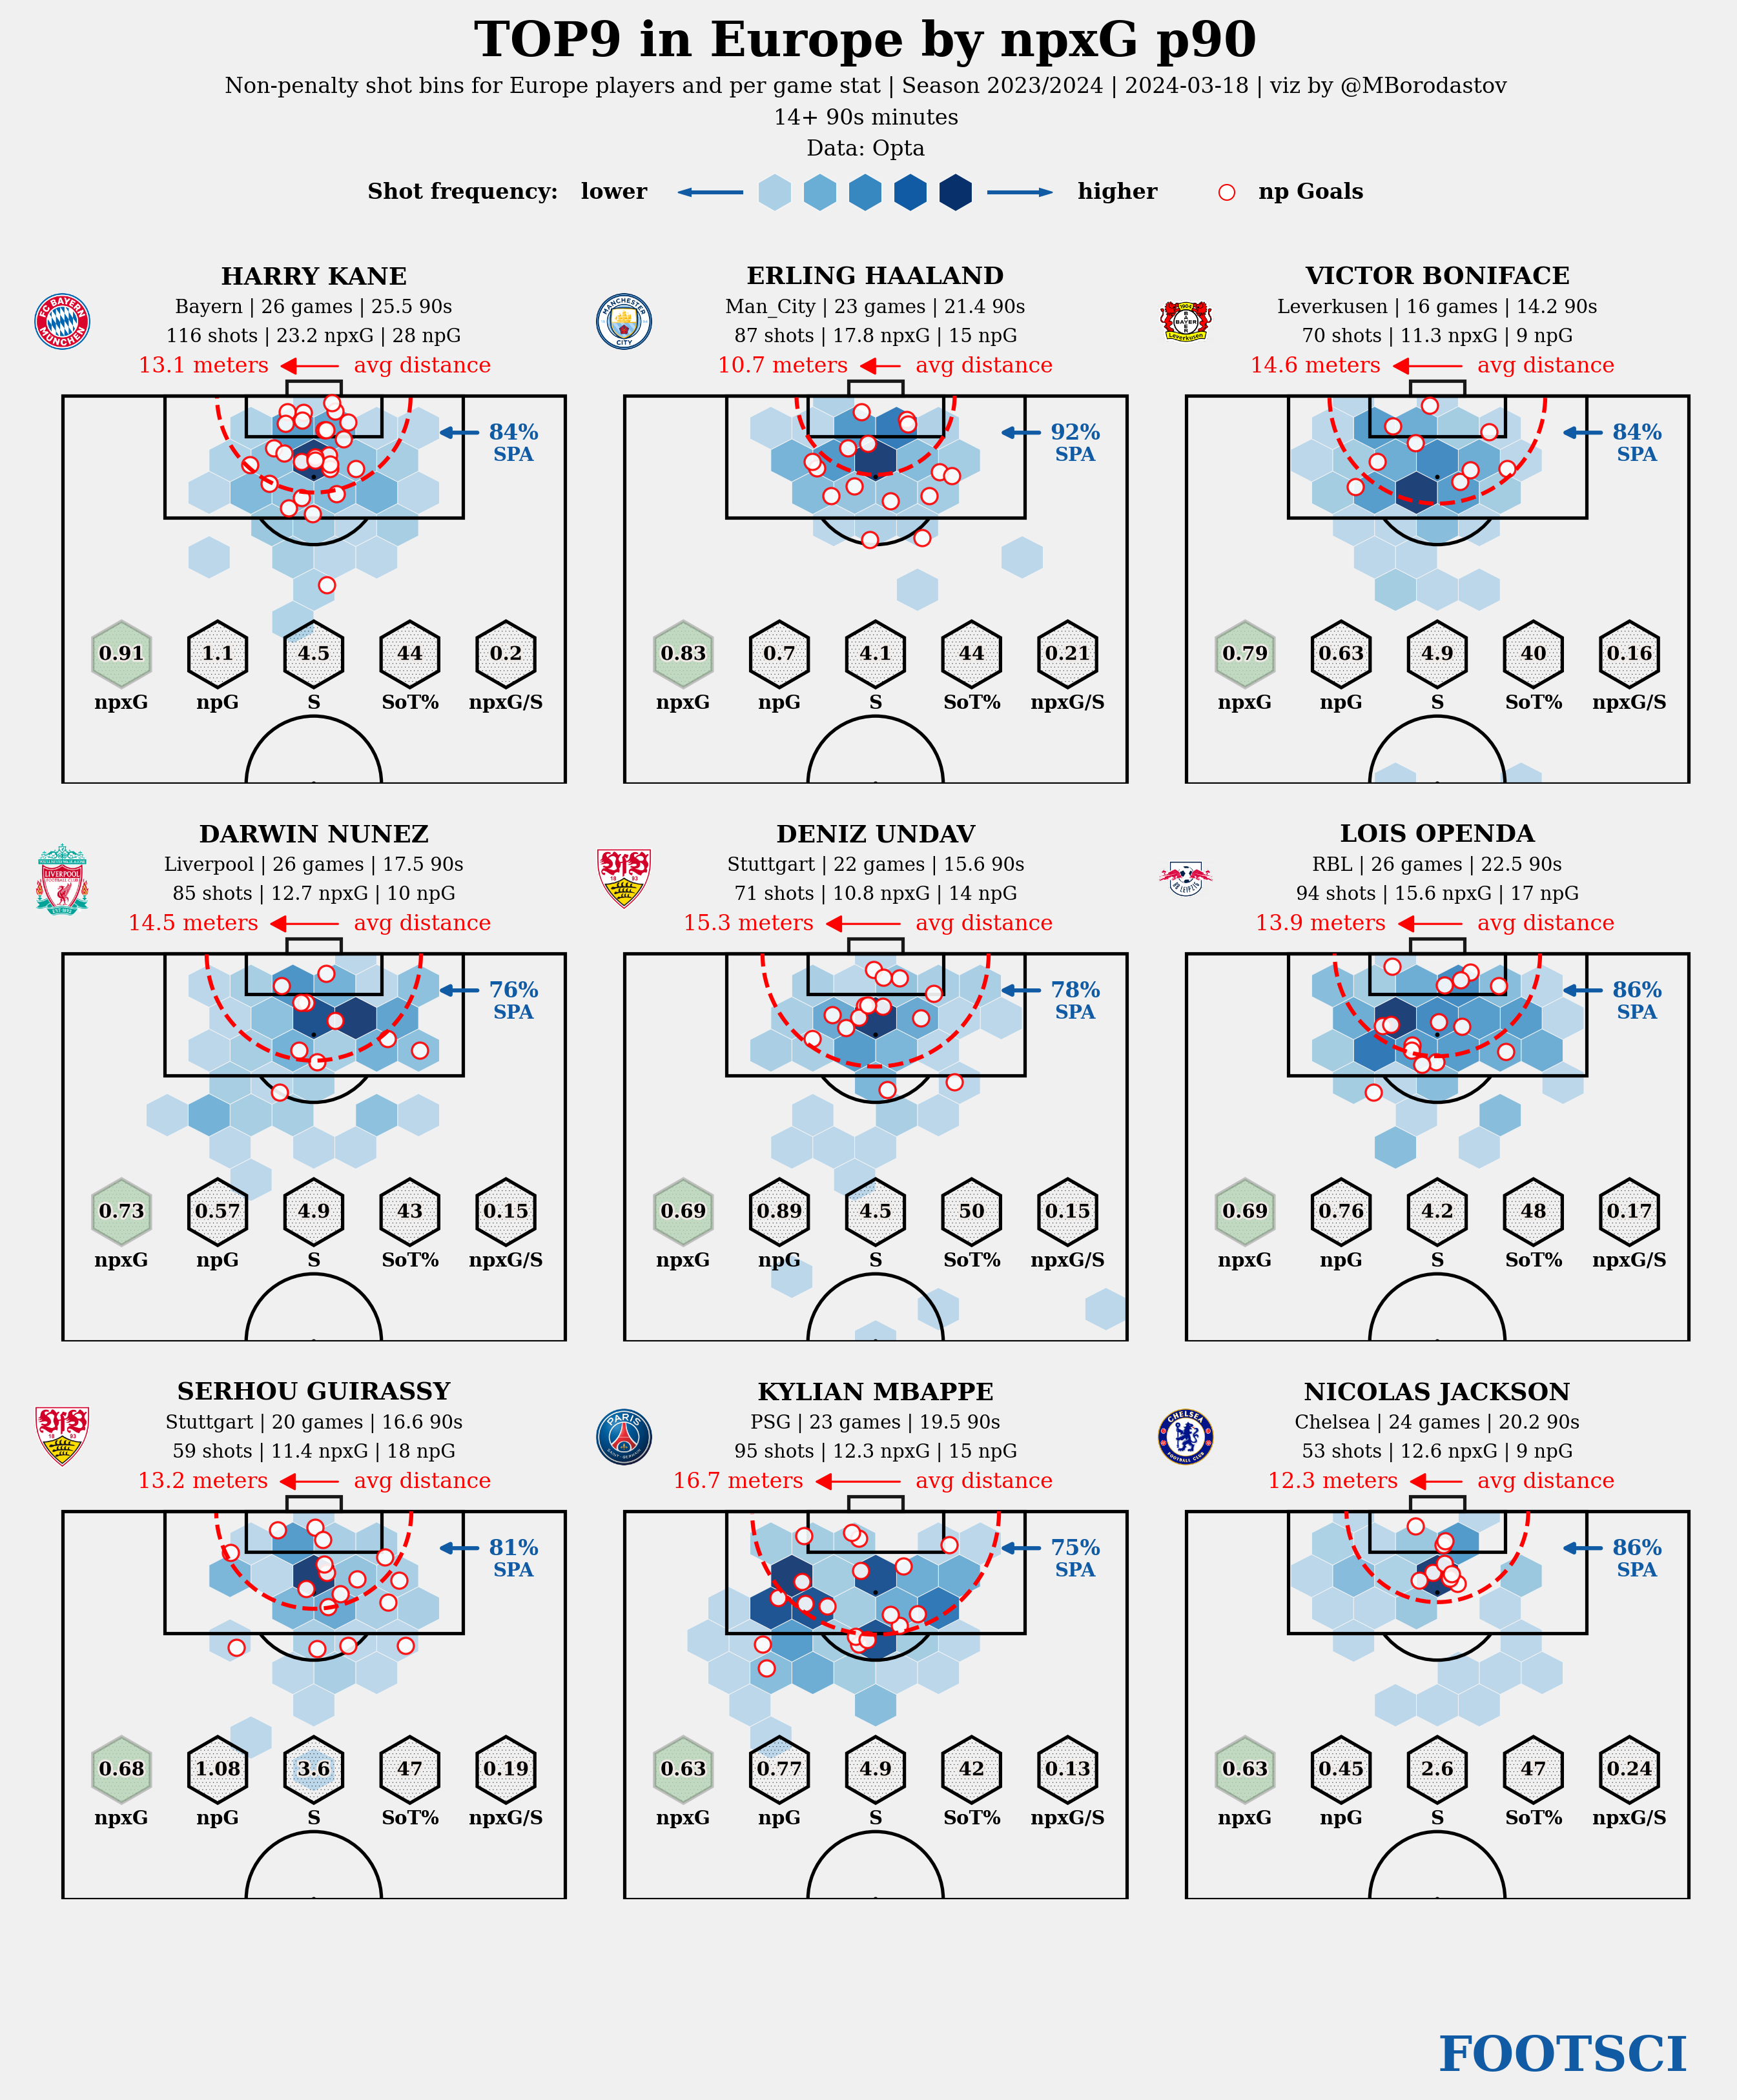

In [65]:
cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
colorlist= mcp.gen_color(cmap='Blues', n=7)
zoom_factor = 0.15

set_plot_environment()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,16), dpi=300)
axs = axs.flatten()  # Flatten the axis array for easy iteration

for index, ax in enumerate(axs):
    pitch = draw_pitch(ax)

    dict_dfs = preprocessing(DF_merged, df_events, index)

    df_all_events = dict_dfs['df_all_events']
    df_goals = dict_dfs['df_goals']
    df_statistic = dict_dfs['df_statistic']

    plot_statistics(ax, pitch, df_all_events, df_goals, cmap)
    add_image(ax, df_statistic['path_logo'].values[0], (68, 115), zoom_factor)
    plot_semicircle(ax, df_all_events, 105, 34)


    player_info = {
        'playerName': df_statistic['playerName'].values[0],
        'team': df_statistic['teamName'].values[0],
        'games': int(df_statistic['games'].values[0]),
        'minutes_90s': round(df_statistic['minutes_90s'].values[0],1),
        'shots': int(df_statistic['shots'].values[0]),
        'npxg_all': round(df_statistic['npxg'].values[0],2),
        'npgoals': int(df_statistic['goals_pens'].values[0]),
        'share' : df_statistic['share'].values[0],

        'S':round(df_statistic['shots_per90'].values[0],1),
        'SoT%':int(df_statistic['shots_on_target_pct'].values[0]),
        'npG':round(df_statistic['goals_pens_per90'].values[0],2),
        'npxG':round(df_statistic['npxg_per90'].values[0],2),
        'npxG/S':df_statistic['npxg_per_shot'].values[0]
    }

    league = 'Europe' if len(leagues) == 5 else leagues[0]

    add_annotations(ax, df_all_events, player_info, colorlist)
    add_statistics(ax, player_info,  type_=type_)
add_title(fig, ax, player_info, league, date, min_minutes_90s, colorlist, type_=type_ )

plt.subplots_adjust(wspace=0, hspace=-0.6)

if date not in os.listdir('../img/'):
    os.mkdir(f'../img/{date}/')
if league not in os.listdir(f'../img/{date}/'):
    os.mkdir(f'../img/{date}/{league}/')
    
fig.savefig(f'../img/{date}/{league}/shot_map_top{rating_size}_in_{league}_by_{type_}.jpeg', bbox_inches='tight', dpi=300)


### 5.4 TOP SCORERS (ranking by npG), EPL


In [66]:
# leagues = ['Premier-League', 'Bundesliga', 'La-Liga', 'Serie-A', 'Ligue-1']


In [67]:
leagues = ['Serie-A']
min_minutes_90s = 14
rating_size = 9

rating_type = 'goals_pens_per90'
type_ = rating_types[rating_type]

columns = ['player','team','xg','npxg','goals','goals_pens','shots','goals_per_shot','npxg_per_shot',
           'shots_on_target','shots_on_target_pct','average_shot_distance','games', 'minutes_90s','shots_per90',
           'goals_pens_per90','npxg_per90']

mask1 = df_statistics['league_name'].apply(lambda x: x in leagues)
mask2 = df_statistics['minutes_90s'] > min_minutes_90s

df_statistics_filtered = (df_statistics[mask1 & mask2][columns]
                .sort_values([rating_type,'goals_pens_per90'], ascending=[False,False])
                .head(rating_size)
                .reset_index(drop=True)
                 )

print(df_events_gr.shape)
print(df_statistics_filtered.shape)

DF_merged = pd.merge(df_statistics_filtered, df_events_gr, 
             left_on = ['player', 'team'],
             right_on = ['playerName', 'teamName'],
             how='left')

print(DF_merged.shape)

DF_merged['teamName_plot'] = (DF_merged['teamName']
                          .replace('PSG', 'Paris S-G')
                          .replace('RBL','RB Leipzig')
                          .replace('Atletico','Atlético de Madrid')

)

path_ = '../logos'

dict_logo = {'Premier_League':'GB1',
             'Serie_A':'IT1',
             'LaLiga':'ES1',
             'Bundesliga':'L1',
             'Ligue_1':'FR1'}


for n, row in DF_merged.iterrows():
    
    league = row['league_name']
    team_name = row['teamName_plot'].replace('_',' ')
    
    path_to_league_logo = os.path.join(path_, dict_logo[league])
    
    choices = os.listdir(path_to_league_logo)
    
    logo_name_matched = process.extractOne(team_name, choices, score_cutoff=80)
    
    if logo_name_matched != None:
        logo_name_matched = logo_name_matched[0]
        path_return = os.path.join(path_to_league_logo, logo_name_matched)

        DF_merged.loc[n, 'path_logo'] = path_return



(2269, 8)
(9, 17)
(9, 25)


In [68]:
DF_merged[['playerName','teamName','teamName_plot','path_logo']]


playerName  teamName teamName_plot  \
0       Lautaro Martinez     Inter         Inter   
1         Dusan Vlahovic  Juventus      Juventus   
2         Victor Osimhen    Napoli        Napoli   
3        Ademola Lookman  Atalanta      Atalanta   
4          Marcus Thuram     Inter         Inter   
5      Riccardo Orsolini   Bologna       Bologna   
6          Romelu Lukaku      Roma          Roma   
7  Khvicha Kvaratskhelia    Napoli        Napoli   
8         Olivier Giroud  AC_Milan      AC_Milan   

                          path_logo  
0      ../logos/IT1/Inter Milan.png  
1      ../logos/IT1/Juventus FC.png  
2       ../logos/IT1/SSC Napoli.png  
3      ../logos/IT1/Atalanta BC.png  
4      ../logos/IT1/Inter Milan.png  
5  ../logos/IT1/Bologna FC 1909.png  
6          ../logos/IT1/AS Roma.png  
7       ../logos/IT1/SSC Napoli.png  
8         ../logos/IT1/AC Milan.png

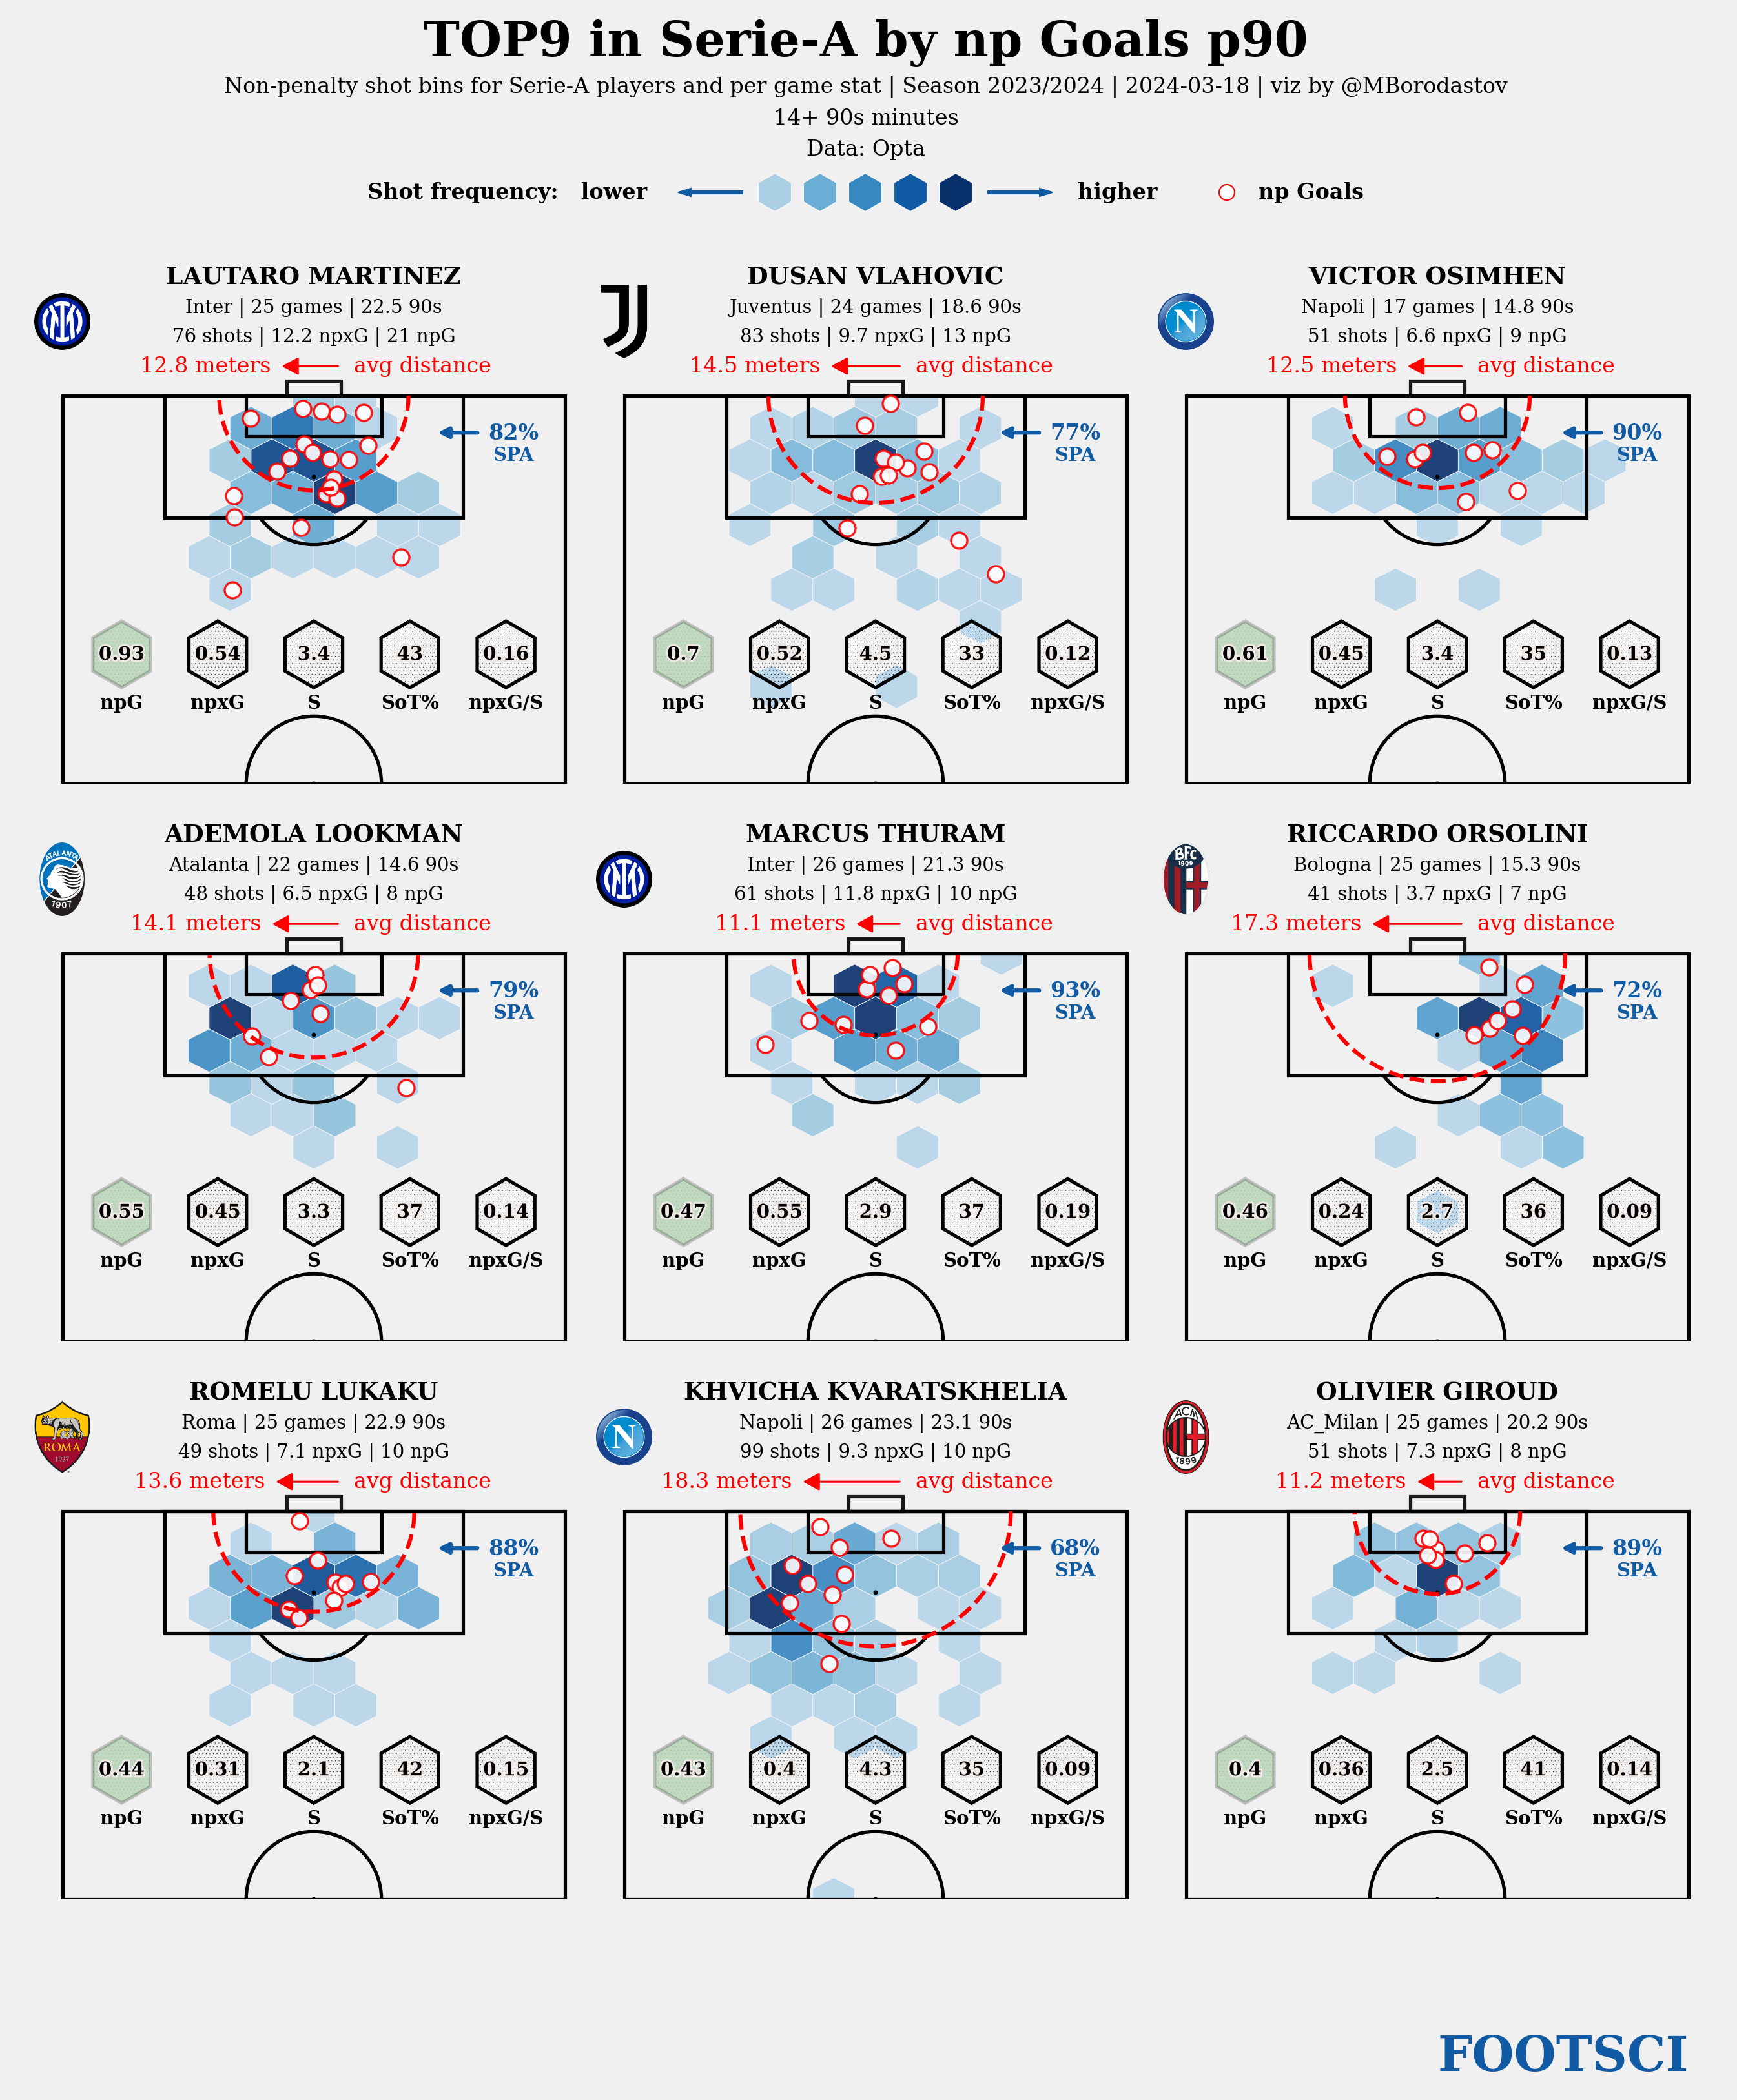

In [69]:
cmap = cmr.get_sub_cmap('Blues', 0.3, 1)
colorlist= mcp.gen_color(cmap='Blues', n=7)
zoom_factor = 0.15

set_plot_environment()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,16), dpi=300)
axs = axs.flatten()  # Flatten the axis array for easy iteration

for index, ax in enumerate(axs):
    pitch = draw_pitch(ax)

    dict_dfs = preprocessing(DF_merged, df_events, index)

    df_all_events = dict_dfs['df_all_events']
    df_goals = dict_dfs['df_goals']
    df_statistic = dict_dfs['df_statistic']

    plot_statistics(ax, pitch, df_all_events, df_goals, cmap)
    add_image(ax, df_statistic['path_logo'].values[0], (68, 115), zoom_factor)
    plot_semicircle(ax, df_all_events, 105, 34)


    player_info = {
        'playerName': df_statistic['playerName'].values[0],
        'team': df_statistic['teamName'].values[0],
        'games': int(df_statistic['games'].values[0]),
        'minutes_90s': round(df_statistic['minutes_90s'].values[0],1),
        'shots': int(df_statistic['shots'].values[0]),
        'npxg_all': round(df_statistic['npxg'].values[0],2),
        'npgoals': int(df_statistic['goals_pens'].values[0]),
        'share' : df_statistic['share'].values[0],

        'S':round(df_statistic['shots_per90'].values[0],1),
        'SoT%':int(df_statistic['shots_on_target_pct'].values[0]),
        'npG':round(df_statistic['goals_pens_per90'].values[0],2),
        'npxG':round(df_statistic['npxg_per90'].values[0],2),
        'npxG/S':df_statistic['npxg_per_shot'].values[0]
    }

    league = 'Europe' if len(leagues) == 5 else leagues[0]

    add_annotations(ax, df_all_events, player_info, colorlist)
    add_statistics(ax, player_info,  type_=type_)
add_title(fig, ax, player_info, league, date, min_minutes_90s, colorlist, type_=type_ )

plt.subplots_adjust(wspace=0, hspace=-0.6)

if date not in os.listdir('../img/'):
    os.mkdir(f'../img/{date}/')
if league not in os.listdir(f'../img/{date}/'):
    os.mkdir(f'../img/{date}/{league}/')
    
fig.savefig(f'../img/{date}/{league}/shot_map_top{rating_size}_in_{league}_by_{type_}.jpeg', bbox_inches='tight', dpi=300)
